# HELLO!

$ x + 1 $

In [3]:
from magnum import Vector3

In [4]:
%%capture
import os
import quaternion
import habitat_sim.sim
import numpy as np
from scipy.io import wavfile


# os.chdir('/home/e4e-student/soundspaces/habitat-sim')
dataset = 'mp3d' # or replace with 'mp3d', one example for each dataset

backend_cfg = habitat_sim.SimulatorConfiguration()
if dataset == 'mp3d':
    backend_cfg.scene_id = "/workspace/data/scene_datasets/forests/test/forest.glb"
    # IMPORTANT: missing this file will lead to load the semantic scene incorrectly
    backend_cfg.scene_dataset_config_file = "/workspace/data/scene_datasets/forests/mp3d.scene_dataset_config.json"
else:
    backend_cfg.scene_id = "/workspace/data/scene-datasets/forests/test/forest.glb"
    # IMPORTANT: missing this file will lead to load the semantic scene incorrectly
    backend_cfg.scene_dataset_config_file = "/workspace/data/dataset_0/test_dataset_0.scene_dataset_config.json"
backend_cfg.load_semantic_mesh = True
backend_cfg.enable_physics = False
agent_config = habitat_sim.AgentConfiguration()
cfg = habitat_sim.Configuration(backend_cfg, [agent_config])
sim = habitat_sim.Simulator(cfg)

# set navmesh path for searching for navigable points
# if dataset == 'mp3d':
#     sim.pathfinder.load_nav_mesh(os.path.join(f"data/scene_datasets/forests/test/forest.navmesh"))
# else:
#     sim.pathfinder.load_nav_mesh(os.path.join(f"data/scene_datasets/gibson/Oyens.navmesh"))

audio_sensor_spec = habitat_sim.AudioSensorSpec()
audio_sensor_spec.uuid = "audio_sensor"
audio_sensor_spec.enableMaterials = True
audio_sensor_spec.channelLayout.channelType = habitat_sim.sensor.RLRAudioPropagationChannelLayoutType.Binaural
audio_sensor_spec.channelLayout.channelCount = 1
# audio sensor location set with respect to the agent
audio_sensor_spec.position = Vector3(0.0, 1.5, 0.0)  # audio sensor has a height of 1.5m
audio_sensor_spec.acousticsConfig.sampleRate = 48000
# whether indrect (reverberation) is present in the rendered IR
audio_sensor_spec.acousticsConfig.indirect = True
sim.add_sensor(audio_sensor_spec)

audio_sensor = sim.get_agent(0)._sensors["audio_sensor"]
# NOTE: got this from https://github.com/facebookresearch/rlr-audio-propagation/blob/main/RLRAudioPropagationPkg/data/mp3d_material_config.json
audio_sensor.setAudioMaterialsJSON("/workspace/data/mp3d_material_config.json")

[00:25:40:638917]:[Warning]:[Metadata] SceneDatasetAttributes.cpp(107)::addNewSceneInstanceToDataset : Dataset : 'mp3d' : Lighting Layout Attributes 'no_lights' specified in Scene Attributes but does not exist in dataset, so creating default.


In [5]:
# sampled navigable point is on the floor
source_pos = sim.pathfinder.get_random_navigable_point() #Vector3(0,0,0)#
print('Sample source location: ', source_pos)

Sample source location:  [-4.457195    0.072447   -0.34131554]


In [6]:
print("hi")

hi


In [7]:
height = Vector3(0,1.5,0)
agent_pos = Vector3(2,0,0)

In [8]:
audio_sensor.setAudioSourceTransform(source_pos + height) # add 1.5m to the height calculation 

In [9]:
agent = sim.get_agent(0)
new_state = sim.get_agent(0).get_state()

In [10]:
#audio_sensor.setAudioSourceTransform(source_pos + height) 

new_state.position = source_pos + agent_pos
new_state.sensor_states = {}
agent.set_state(new_state, True)
ir = np.array(sim.get_sensor_observations()["audio_sensor"]) #BREAKS HERE TODO FIX MODEL MAYBE?
#print(ir.shape)

# one a category is not found in the material mapping file, the default acoustic material will be used.

CreateContext: Context created


Material for category 'picture' was not found. Using default material instead.
Material for category 'objects' was not found. Using default material instead.
Material for category 'void' was not found. Using default material instead.
Material for category 'misc' was not found. Using default material instead.


In [11]:
# This bit of code crashes. Unsure why, trying to review this
#sim.get_sensor_observations()

In [12]:
# check if the direct sound is present (source is visibile from the listener)
#audio_sensor.sourceIsVisible()
# Note this does not appear to exist in newer habitat sim...

In [13]:
# check the efficiency of rendering, outdoor would have a very low value, e.g. < 0.05, 
# while a closed indoor room would have >0.95, and a room with some holes might be in the 0.1-0.8 range.
# if the ray efficiency is low for an indoor environment, it indicates a lot of ray leak from holes
# you should repair the mesh in this case for more accurate acoustic rendering
# audio_sensor.getRayEfficiency()
# Note this does not appear to exist in newer habitat sim...

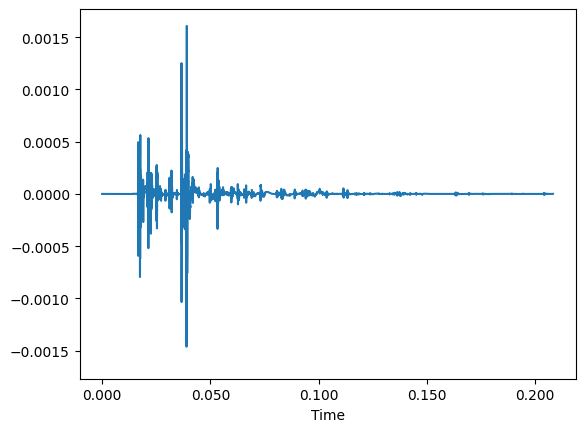

In [14]:
# plot the waveform of IR and show the audio
from librosa.display import waveshow, specshow
import IPython

waveshow(ir[0, :10000], sr=48000)
IPython.display.Audio(ir, rate=48000)

In [15]:
#!pip install librosa

In [16]:
# one example for how to use IR data to get the reverberant speech
import librosa
#sr, vocal = wavfile.read('res/singing.wav')
vocal, sr = librosa.load(path="/workspace/XC150592 - Screaming Piha - Lipaugus vociferans.mp3")
print(sr, vocal.shape)
IPython.display.Audio(vocal, rate=sr)

22050 (73152,)


In [17]:
from scipy.signal import fftconvolve

# convolve the vocal with IR
convolved_vocal = np.array([fftconvolve(vocal, ir_channel) for ir_channel in ir]) 
IPython.display.Audio(convolved_vocal, rate=sr)

In [18]:
convolved_vocal.shape, vocal.shape

((2, 108728), (73152,))

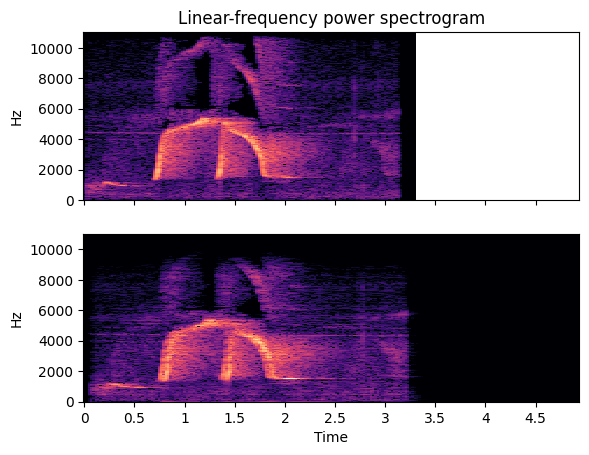

In [19]:
import matplotlib.pyplot as plt
import numpy as np

y = vocal
y_ = convolved_vocal

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)

D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
D_ = librosa.amplitude_to_db(np.abs(librosa.stft(y_.mean(axis=0))), ref=np.max)

img = librosa.display.specshow(D, y_axis='linear', x_axis='time',

                               sr=sr, ax=ax[0])

img = librosa.display.specshow(D_, y_axis='linear', x_axis='time',

                               sr=sr, ax=ax[1])

ax[0].set(title='Linear-frequency power spectrogram')

ax[0].label_outer()

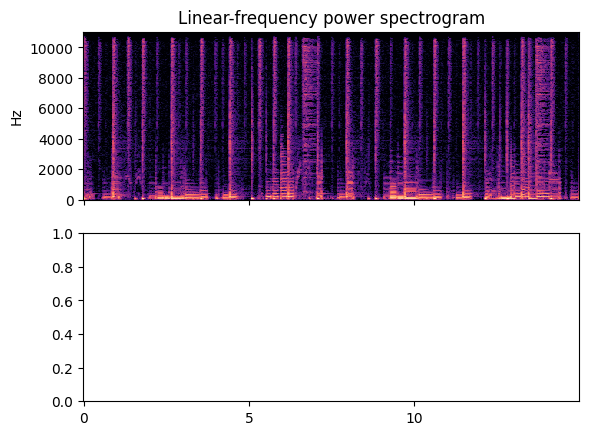

In [20]:
import matplotlib.pyplot as plt

y, sr = librosa.load(librosa.ex('choice'), duration=15)

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)

D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

img = librosa.display.specshow(D, y_axis='linear', x_axis='time',

                               sr=sr, ax=ax[0])

ax[0].set(title='Linear-frequency power spectrogram')

ax[0].label_outer()

In [21]:
# from pyroomacoustics.experimental.rt60 import measure_rt60

# rt60 = measure_rt60(ir[0], sr, decay_db=30, plot=True)
# print(f'RT60 of the rendered IR is {rt60:.4f} seconds')